<a href="https://www.kaggle.com/code/thelilblack/arrhythmia-detection-cnn-new?scriptVersionId=102912914" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<center><h1 class="list-group-item list-group-item-success">Arrhythmia Detection</h1></center>

In [1]:
# Importing Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv1D
import wfdb                            # Package for loading the ecg and annotation
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore") 
import random
from keras.layers import Bidirectional, LSTM
# Random Initialization
random.seed(42)

In [2]:
# Importing Data
data = '../input/mit-bih-arrhythmia-database/'

In [3]:
# List of Patients
patients = ['100','101','102','103','104','105','106','107',
           '108','109','111','112','113','114','115','116',
           '117','118','119','121','122','123','124','200',
           '201','202','203','205','207','208','209','210',
           '212','213','214','215','217','219','220','221',
           '222','223','228','230','231','232','233','234']

In [4]:
# Creating a Empty Dataframe
symbols_df = pd.DataFrame()

# Reading all .atr files 
for pts in patients:
    # Generating filepath for all .atr file names
    file = data + pts
    # Saving annotation object
    annotation = wfdb.rdann(file, 'atr')
    # Extracting symbols from the object
    sym = annotation.symbol
    # Saving value counts
    values, counts = np.unique(sym, return_counts=True)
    # Writing data points into dataframe
    df_sub = pd.DataFrame({'symbol':values, 'Counts':counts, 'Patient Number':[pts]*len(counts)})
    # Concatenating all data points  
    symbols_df = pd.concat([symbols_df, df_sub],axis = 0)

In [5]:
# Value Counts of Different symbols in data
symbols_df.groupby('symbol').Counts.sum().sort_values(ascending = False)

symbol
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: Counts, dtype: int64

In [6]:
# Non Beat Symbols
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']

# Abnormal Beat Symbols
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

# Normal Beat Symbols
normal = ['N']

In [7]:
# Classifying normal, abnormal or nonbeat
symbols_df['category'] = -1
symbols_df.loc[symbols_df.symbol == 'N','category'] = 0
symbols_df.loc[symbols_df.symbol.isin(abnormal), 'category'] = 1

In [8]:
# Value counts of different categories
symbols_df.groupby('category').Counts.sum()

category
-1     3186
 0    75052
 1    34409
Name: Counts, dtype: int64

In [9]:
def load_ecg(file):    
    # load the ecg
    record = wfdb.rdrecord(file)
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
    
    # extracting the signal
    p_signal = record.p_signal

    # extracting symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample

In [10]:
# Accessing the load ECG function and getting annotation.symbol, annotation.sample, signals
p_signal, atr_sym, atr_sample = load_ecg(file)

In [11]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    #   pts - list of patients
    #   num_sec = number of seconds to include before and after the beat
    #   fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
        
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    return X_all, Y_all, sym_all


In [12]:
def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [13]:
# Parameter Values
num_sec = 5
fs = 360

In [14]:
# Accessing the fuction and creating a dataset with ECG digital Points
X_all, Y_all, sym_all = make_dataset(patients, num_sec, fs, abnormal)

In [15]:
# Train Test Split|
X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

In [16]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
import os
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LayerNormalization
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [17]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.layers.core import Dense,Activation,Dropout,Flatten
from keras.utils import np_utils
from keras import *
import tensorflow as tf

import os
from six.moves import cPickle as pickle
import platform
import numpy as np

In [18]:
# Evaluation Metrics
def print_report(y_actual, y_pred, thresh):
    # Function to print evaluation metrics
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
    prevalence = (sum(y_actual)/len(y_actual))
    print('AUC:%.3f'%auc)
    print('Accuracy:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precision:%.3f'%precision)
    print('Specificity:%.3f'%specificity)
    print('Prevalence:%.3f'%prevalence)
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [19]:
# Threshold Value
thresh = (sum(y_train)/len(y_train))[0]

In [20]:
# reshape input to [samples, time steps, features = 1] for CNN
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(87083, 3600, 1)
(21771, 3600, 1)


In [21]:
# Relu for activation function & Dropout for reducing overfitting by randomly removing some nodes.
model = Sequential()
model.add(Conv1D(filters = 1024, kernel_size = 5, activation = 'relu', input_shape = (X_train.shape[1],1)))
model.add(Dropout(rate = 0.25))
model.add(Conv1D(128, kernel_size = 5, activation = 'relu', padding='same'))
model.add(MaxPool1D())
model.add(Dropout(rate = 0.5))
model.add(Flatten())
model.add(Dense(1024))
model.add(Dense(128))
model.add(Dense(1, activation = 'sigmoid'))

# compile the model with binary crossentropy, and the adam optimizer
model.compile(loss = 'binary_crossentropy',
                optimizer = 'sgd',
                metrics = ['accuracy'])

2022-08-09 17:25:58.050999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 17:25:58.163076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 17:25:58.163862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 17:25:58.165113: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3596, 1024)        6144      
_________________________________________________________________
dropout (Dropout)            (None, 3596, 1024)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3596, 128)         655488    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1798, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1798, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 230144)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2

In [23]:
# Fitting data in model 
model.fit(X_train_cnn, y_train, batch_size = 32, epochs= 50, verbose = 1)

2022-08-09 17:26:01.604255: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1253995200 exceeds 10% of free system memory.
2022-08-09 17:26:03.043925: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1253995200 exceeds 10% of free system memory.
2022-08-09 17:26:04.082614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-09 17:26:05.416347: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2722/2722 [==============================] - 298s 107ms/step - loss: 0.2794 - accuracy: 0.8917
Epoch 2/50
2722/2722 [==============================] - 290s 107ms/step - loss: 0.1844 - accuracy: 0.9394
Epoch 3/50
2722/2722 [==============================] - 290s 106ms/step - loss: 0.1582 - accuracy: 0.9482
Epoch 4/50
2722/2722 [==============================] - 290s 106ms/step - loss: 0.1382 - accuracy: 0.9544
Epoch 5/50
2722/2722 [==============================] - 290s 106ms/step - loss: 0.1213 - accuracy: 0.9598
Epoch 6/50
2722/2722 [==============================] - 290s 107ms/step - loss: 0.1074 - accuracy: 0.9644
Epoch 7/50
2722/2722 [==============================] - 290s 106ms/step - loss: 0.0977 - accuracy: 0.9680
Epoch 8/50
2722/2722 [==============================] - 290s 107ms/step - loss: 0.0880 - accuracy: 0.9709
Epoch 9/50
2722/2722 [==============================] - 290s 107ms/step - loss: 0.0816 - accuracy: 0.9731
Epoch 10/50
2722/2722 [==============================] - 

In [24]:
# Predictions
y_train_preds_cnn = model.predict(X_train_cnn,verbose = 1)
y_valid_preds_cnn = model.predict(X_valid_cnn,verbose = 1)

2022-08-09 21:29:36.778109: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1253995200 exceeds 10% of free system memory.
2022-08-09 21:29:38.423079: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1253995200 exceeds 10% of free system memory.


2722/2722 [==============================] - 81s 30ms/step


2022-08-09 21:31:01.597769: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 313502400 exceeds 10% of free system memory.


681/681 [==============================] - 20s 30ms/step


In [25]:
# Metrics
print('Train');
print_report(y_train, y_train_preds_cnn, thresh)
print('Valid');
print_report(y_valid, y_valid_preds_cnn, thresh);

Train
AUC:1.000
Accuracy:0.999
Recall:0.999
Precision:0.999
Specificity:1.000
Prevalence:0.315
 
Valid
AUC:0.994
Accuracy:0.979
Recall:0.963
Precision:0.969
Specificity:0.986
Prevalence:0.313
 


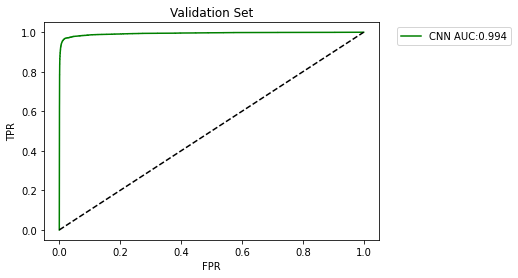

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)




plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)



plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()
